# SFMTA using patridges

Importing the package and setting the path for the file

In [1]:
import partridge as ptg
path = 'sfmta' # this is the subfolder within your GitHub repository


Currently, this reads the busiest date in the given date frame of the file i have inputted.

I would want it to: read for all dates and do the analysis. I will have to make a `for` loop

In [2]:
date, service_ids = ptg.read_busiest_date(path)

In [7]:
df=ptg.read_trip_counts_by_date(path)

In [10]:
sorted(df)

[datetime.date(2022, 7, 30),
 datetime.date(2022, 7, 31),
 datetime.date(2022, 8, 1),
 datetime.date(2022, 8, 2),
 datetime.date(2022, 8, 3),
 datetime.date(2022, 8, 4),
 datetime.date(2022, 8, 5),
 datetime.date(2022, 8, 6),
 datetime.date(2022, 8, 7),
 datetime.date(2022, 8, 8),
 datetime.date(2022, 8, 9),
 datetime.date(2022, 8, 10),
 datetime.date(2022, 8, 11),
 datetime.date(2022, 8, 12),
 datetime.date(2022, 8, 13),
 datetime.date(2022, 8, 14),
 datetime.date(2022, 8, 15),
 datetime.date(2022, 8, 16),
 datetime.date(2022, 8, 17),
 datetime.date(2022, 8, 18),
 datetime.date(2022, 8, 19),
 datetime.date(2022, 8, 20),
 datetime.date(2022, 8, 21),
 datetime.date(2022, 8, 22),
 datetime.date(2022, 8, 23),
 datetime.date(2022, 8, 24),
 datetime.date(2022, 8, 25),
 datetime.date(2022, 8, 26),
 datetime.date(2022, 8, 27),
 datetime.date(2022, 8, 28),
 datetime.date(2022, 8, 29),
 datetime.date(2022, 8, 30),
 datetime.date(2022, 8, 31),
 datetime.date(2022, 9, 1),
 datetime.date(2022, 9, 

we use `ptg.load_geo_feed` to get the feed for the day. We pass the path, and a dictionary that contains  all service ids. It pulls data from the text files in the path, and returns the feed. We can get different types of feed - with or without geometry I think.
The `feed` object we get at the end contains all the gtfs data as its instances, which we can call using the `.` dot notation. 

In [3]:
ptg.load_geo_feed?

Signature:
ptg.load_geo_feed(
    path: str,
    view: Optional[Dict[str, Dict[str, Any]]] = None,
) -> partridge.gtfs.Feed
Docstring: <no docstring>
File:      ~/opt/anaconda3/envs/uds/lib/python3.10/site-packages/partridge/readers.py
Type:      function

In [4]:
view = {'trips.txt': {'service_id': service_ids}}

feed = ptg.load_geo_feed(path, view)

Examples: displaying agency, calendar, stops, 

We can also plot two of these columns :  shapes and stops

In [5]:
feed.agency

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,agency_fare_url
0,6216179,Big Blue Bus,http://www.bigbluebus.com,America/Los_Angeles,en,310-451-5444,NaN


In [6]:
#feed.calendar

In [7]:
#feed.stops.head()

/Users/chaithra/opt/anaconda3/envs/uds/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

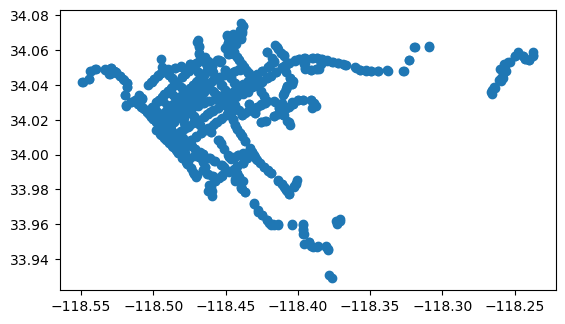

In [8]:
feed.stops.plot()


/Users/chaithra/opt/anaconda3/envs/uds/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

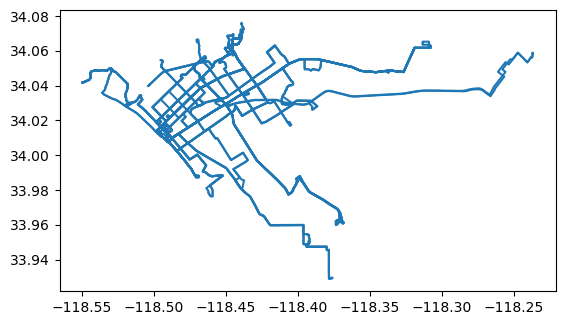

In [9]:
feed.shapes.plot()

## Possible analysis

_From class_: Let's compute and map a simple measure of transit accessibility (number of trips per day) at the stop level. We want a count of the number of trips at each stop. We saw above that stop_times had the stop id. So let's do the following:

- Aggregate stop_times by stop_id to generate counts
- Join this to the stops data (which has the geometry)
- Map the results


In [11]:
freqs = feed.stop_times.groupby('stop_id').size()
# join on the index
freqs.name = 'n_trips'
stops = feed.stops.set_index('stop_id').join(freqs)

The markers are a little large. Let's create a new column with a scaled version of the marker size, and plot that instead.

[]

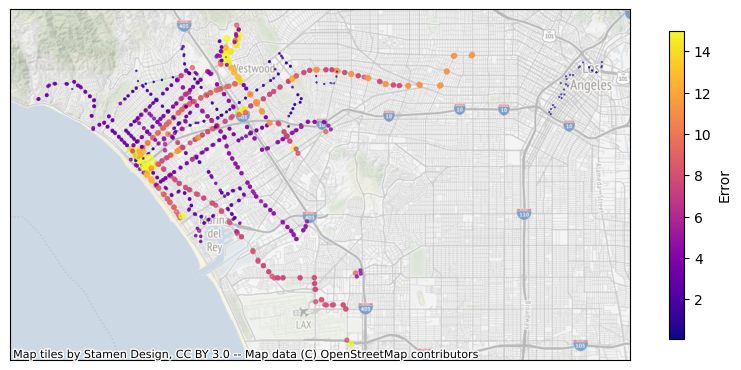

In [16]:
stops['n_trips_scaled']= stops.n_trips / 10

import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd


# same code as before, except for plotting n_trips_scaled instead of n_trips
fig, ax = plt.subplots(figsize=(10,10))
stops.to_crs('EPSG:3857').plot(column='n_trips_scaled', #needed to set the cmap to the value rather than route 
                               markersize='n_trips_scaled', 
                               ax=ax, cmap='plasma', 
                               legend=True,
                               vmax=15,
                               legend_kwds={'orientation': 'vertical', 'shrink': .4, 'label':"Error"}, 
                               alpha=0.7)
ctx.add_basemap(ax, zoom=12, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])

These accessibility measures are at the stop level, but you can imagine aggregating the combined frequencies to census tracts, and/or calculating the combined frequency within (say) 0.25 miles of a destination.

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>GTFS is the standard format for transit data</li>
  <li>GTFS is cumbersome to work with in raw form, but partridge makes it simpler</li>
</ul>
</div>

## Todo:
* [ ] A function to do this 
* [ ] How do repeare this for different date/times within the range
* [ ] How can I do this on segments or shape routes, instead of stops.
* [ ] To do it for average dates, etc

## Getting time in format
I try to figure out how to get 24hr `(hh:mm:ss)` for the time from stop-times. This will then allow me to filter for all peak hour values lateron

In [28]:
import pandas as pd
from datetime import datetime, timedelta

In [31]:
# # converting float time into 24hr format
# duration_seconds = 34332.0
# duration = datetime.timedelta(seconds=duration_seconds)

# print(duration)

In [29]:
# Datetime from seconds in float to hh:mm:ss format
df=feed.stop_times
# https://stackoverflow.com/questions/53129971/remove-the-days-in-the-timedelta-object
df['time_hhmm']=feed.stop_times.arrival_time.apply(lambda x:timedelta(seconds=x))
df['time_hhmm']= df['time_hhmm'].apply(lambda x:str(x)[7:15])
df['time_hhmm']

0        06:07:00
1        06:07:35
2        06:08:26
3        06:09:17
4        06:10:11
           ...   
47940    06:58:00
47941    06:58:53
47942    06:59:59
47943    07:01:04
47944    07:02:00
Name: time_hhmm, Length: 47945, dtype: object

### Way to group data by date for each unique service id

In [102]:
# # figuring out unique dates for each service id 
# # was trying to make a disctionary, but it is not very useful as we need full table to be able to work on

# data = {
#     'service_id': df['service_id'].unique(), {'date': df['date'].unique()}
# }

# # Assuming the data is stored in a DataFrame called 'df'
# service_ids = df['service_id'].unique().tolist()
# dates = df['date'].unique().tolist()

# data = {
#     'service_id': {sid: {'date': dates} for sid in service_ids}
# }

# grouped_data = df.groupby('service_id')['date'].unique()

# # Convert the grouped data into a dictionary
# data = grouped_data.to_dict()


## figure out - parsed time function in partridge - it converts a hh:mm:ss time into seconds.

technically, we can measure the delay/speed in seconds and sort peak time by using approrpiate second values

In [55]:
from partridge.parsers import parse_time, parse_date, vparse_date, vparse_time

arrival_time = str(feed.stop_times.arrival_time[1])

# parsed_time = 
am_peak_s=parse_time('07:00:00')
am_peak_e=parse_time('09:00:00')
pm_peak_s=parse_time('16:00:00')
pm_peak_e=parse_time('19:00:00')

array([25200., 14400.])

## Reading feed as a gfd

In [32]:
feed2 = ptg.load_geo_feed(path, view)

<Axes: >

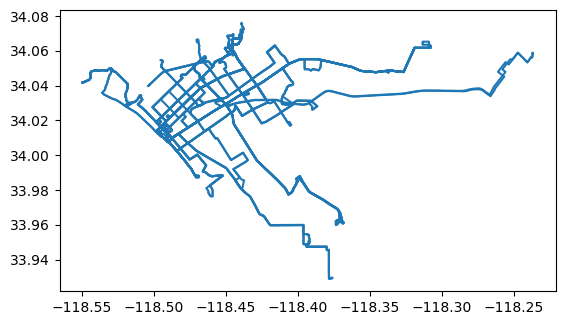

In [40]:
minlon, minlat, maxlon, maxlat = feed2.stops.total_bounds

In [43]:
type(feed.shapes)

geopandas.geodataframe.GeoDataFrame